In [8]:
import numpy as np
import pandas as pd
import time
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
from scipy.stats import binom
from scipy.stats import poisson
from scipy.stats import norm
from IPython import display

from scipy.stats import norm
import statistics

In [9]:
# Read in all the files of data
file_base = pd.read_csv("data/Europium_152_Data_2021-11-19_D3S.csv")
file_background = pd.read_csv("data/Background_Data_2021-11-19_D3S.csv")
file1 = pd.read_csv("data/Unknown_1_Data_2021-11-19_D3S.csv")
file2 = pd.read_csv("data/Unknown_2_Data_2021-11-19_D3S.csv")
file3 = pd.read_csv("data/Unknown_3_Data_2021-11-19_D3S.csv")


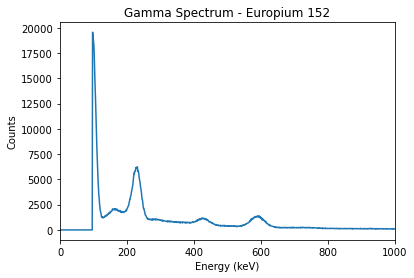

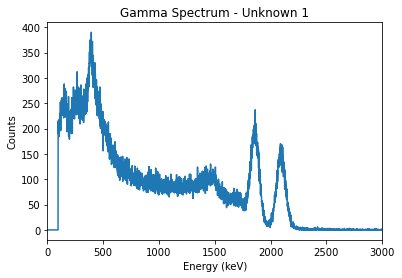

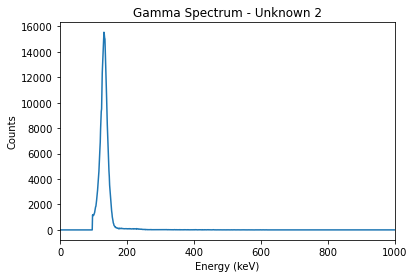

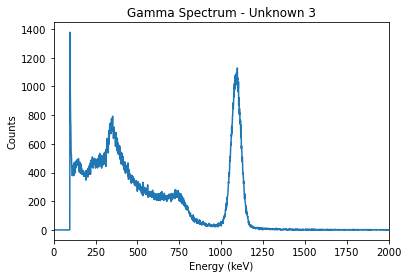

In [10]:
file_base_cols = np.add.reduce(file_base, axis=0)
file_background_cols = np.add.reduce(file_background, axis=0)
file1_cols = np.add.reduce(file1, axis=0)
file2_cols = np.add.reduce(file2, axis=0)
file3_cols = np.add.reduce(file3, axis=0)

plt.plot(file_base_cols)
plt.xlim([0,1000])
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("Gamma Spectrum - Europium 152")
plt.show()

plt.plot(file1_cols)
plt.xlim([0,3000])
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("Gamma Spectrum - Unknown 1")
plt.show()

plt.plot(file2_cols)
plt.xlim([0,1000])
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("Gamma Spectrum - Unknown 2")
plt.show()

plt.plot(file3_cols)
plt.xlim([0,2000])
plt.ylabel("Counts")
plt.xlabel("Energy (keV)")
plt.title("Gamma Spectrum - Unknown 3")
plt.show()


In [11]:
def propagate_uncertainty(partial_1, partial_2, partial_3, sigma_1, sigma_2, sigma_3):
    # Takes in 6 arguments - partials with respect to 3 different variables, and each variables uncertainty
    # Returns - The new propagated uncertainty for the function
    return math.sqrt(partial_1**2 * sigma_1**2 + partial_2**2 * sigma_2**2 + partial_3**2 * sigma_3**2)

def get_activity(efficiency, efficiency_uncertainty, cps, background):
    # Takes in 3 arguments - detector efficiency, the uncertainty on the efficiency, and the counts-per-second
    # Returns - A tuple with the first value containing the calculated activity, and the second values containing its uncertainty
    return ((cps / efficiency) - background, propagate_uncertainty(1/efficiency, cps, -1, math.sqrt(cps), efficiency_uncertainty, math.sqrt(background)))


def find_source(knowns_dict, unknowns_dict):
    # Takes in 2 arguments - a dictionary with keys/values for known activities/sources, a dictionary with keys/values for unknown activities/sources
    # Returns - An array of tuples; Each tuple contains a label for an unknown source, and its matching known source
                                                                                           # Ex. ("Sample 1, U-238")
    
    knowns = list(knowns_dict.keys())
    unknowns = list(unknowns_dict.keys())

    all_pairs = []
    result = []
    
    all_pairs.append(list(zip(unknowns, knowns)))
        
    for i in range(1, len(knowns)):
        all_pairs.append(list(zip(unknowns, knowns[i:] + knowns[:i])))
        
    error = lambda x: sum([(n[0]-n[1])**2 for n in x])
    
    least_error = min(all_pairs, key=error)
    
    for element in least_error:
        result.append((unknowns_dict[element[0]], knowns_dict[element[1]]))
    
    return result
    


In [12]:
eu = 213345.9
co = 126914.07 
am = 363329.38
cs = 310132.56

npArrBase = file_base.to_numpy()
EuCps = np.nansum(npArrBase)/(npArrBase.shape[0] * 5)

efficiency = EuCps/eu
e_uncertainty = propagate_uncertainty(1/eu, -EuCps/eu**2, 0, math.sqrt(EuCps), math.sqrt(eu), 0)


npArr1 = file1.to_numpy()
totalCps1 = npArr1.sum() / (npArr1.shape[0] * 5)

npArr2 = file2.to_numpy()
totalCps2 = npArr2.sum()/(npArr2.shape[0] * 5)

npArr3 = file3.to_numpy()
totalCps3 = npArr3.sum()/(npArr3.shape[0] * 5)

npArrBackground = file_background.to_numpy()
totalCpsBackground = npArrBackground.sum()/(npArr3.shape[0] * 5)

In [13]:
known_values = {126914.07: "Cobalt-60", 363329.38: "Americium-241", 310132.56: "Caesium-137"}

unknown_values = {get_activity(efficiency, e_uncertainty, totalCps1, totalCpsBackground)[0]: "Unknown1", 
                  get_activity(efficiency, e_uncertainty, totalCps2, totalCpsBackground)[0]: "Unknown2",
                  get_activity(efficiency, e_uncertainty, totalCps3, totalCpsBackground)[0]: "Unknown3"}


final_result = find_source(known_values, unknown_values)

print(f"Calculated Activity for Unknown 1: {round(get_activity(efficiency, e_uncertainty, totalCps1, totalCpsBackground)[0], 3)} Bq +/- {round(get_activity(efficiency, e_uncertainty, totalCps1, totalCpsBackground)[1], 3)} Bq")
print(f"Calculated Activity for Unknown 2: {round(get_activity(efficiency, e_uncertainty, totalCps2, totalCpsBackground)[0], 3)} Bq +/- {round(get_activity(efficiency, e_uncertainty, totalCps2, totalCpsBackground)[1], 3)} Bq")
print(f"Calculated Activity for Unknown 3: {round(get_activity(efficiency, e_uncertainty, totalCps3, totalCpsBackground)[0], 3)} Bq +/- {round(get_activity(efficiency, e_uncertainty, totalCps3, totalCpsBackground)[1], 3)} Bq")
print("\n")
print(f"Based on our data and calculations for efficiency, these are the matching samples: \n{final_result}")


Calculated Activity for Unknown 1: 141310.274 Bq +/- 6177.429 Bq
Calculated Activity for Unknown 2: 231436.397 Bq +/- 7905.463 Bq
Calculated Activity for Unknown 3: 157966.979 Bq +/- 6531.328 Bq


Based on our data and calculations for efficiency, these are the matching samples: 
[('Unknown1', 'Cobalt-60'), ('Unknown2', 'Americium-241'), ('Unknown3', 'Caesium-137')]
